In [1]:
import os
import sys
sys.path.append('D:\\Users\\Hegxiten\\workspace\\Rutgers_Railway_security_research\\OOD_Train')

from datetime import datetime, timedelta
import numpy as np
import random
from infrastructure import Track, BigBlock
from signaling import AutoSignal, HomeSignal, AutoPoint, ControlPoint
from system import System
from train import Train
import networkx as nx


In [2]:
sim_init_time = datetime.strptime('2018-01-10 10:00:00', "%Y-%m-%d %H:%M:%S")
sim_term_time = datetime.strptime('2018-01-10 15:30:00', "%Y-%m-%d %H:%M:%S")
sp_container = [random.uniform(0.01, 0.02) for i in range(20)]
acc_container = [0.5*random.uniform(2.78e-05*0.85, 2.78e-05*1.15) for i in range(20)]
dcc_container = [0.2*random.uniform(2.78e-05*0.85, 2.78e-05*1.15) for i in range(20)]
headway = 200 * random.random() + 400
sys = System(sim_init_time, sp_container, acc_container, dcc_container,
             dos_period=['2018-01-10 11:30:00', '2018-01-10 12:30:00'],  
             dos_pos=-1,
             headway=headway, 
             refresh_time=10)

K166 = Train(system=sys, 
                  init_time=sys.sys_time, 
                  init_segment=((None,None),(sys.signal_points[10],1)),
                  max_sp=sys.sp_container[sys.train_num % len(sys.sp_container)], 
                  max_acc=sys.acc_container[sys.train_num % len(sys.acc_container)], 
                  max_dcc=sys.dcc_container[sys.train_num % len(sys.dcc_container)],
                  length=1)

# T166 = Train(system=sys, 
#                   init_time=sys.sys_time, 
#                   init_segment=((sys.signal_points[5],0),(sys.signal_points[4],1)),
#                   max_sp=sys.sp_container[sys.train_num % len(sys.sp_container)], 
#                   max_acc=sys.acc_container[sys.train_num % len(sys.acc_container)], 
#                   max_dcc=sys.dcc_container[sys.train_num % len(sys.dcc_container)],
#                   length=1)

# K165 = Train(system=sys, 
#                   init_time=sys.sys_time, 
#                   init_segment=((sys.signal_points[2],1),(sys.signal_points[3],0)),
#                   max_sp=sys.sp_container[sys.train_num % len(sys.sp_container)], 
#                   max_acc=sys.acc_container[sys.train_num % len(sys.acc_container)], 
#                   max_dcc=sys.dcc_container[sys.train_num % len(sys.dcc_container)],
#                   length=1)

# T165 = Train(system=sys, 
#                   init_time=sys.sys_time, 
#                   init_segment=((sys.signal_points[3],1),(sys.signal_points[4],0)),
#                   max_sp=sys.sp_container[sys.train_num % len(sys.sp_container)], 
#                   max_acc=sys.acc_container[sys.train_num % len(sys.acc_container)], 
#                   max_dcc=sys.dcc_container[sys.train_num % len(sys.dcc_container)],
#                   length=1)

In [3]:
while not K166.terminated:
    K166.request_routing()
    K166.update_acc()
    sys.sys_time+=sys.refresh_time

train index 0, current occupation: [((None, None), (ControlPoint10, 1))], head MP: 50.00, rear MP 51.00 requesting (1, 0) at ControlPoint10
route (1, 0) of ControlPoint10 is opened
train train index 0, current occupation: [((None, None), (ControlPoint10, 1))], head MP: 50.00, rear MP 51.00 initiated entering into track Track MP: 45.0 to MP: 50.0 idx: 0
route (1, 0) of ControlPoint10 is closed
train index 0, current occupation: [((ControlPoint10, 0), (AutoPoint9, 1)), ((None, None), (ControlPoint10, 1))], head MP: 50.00, rear MP 51.00 requesting (1, 0) at ControlPoint7
route (1, 0) of ControlPoint7 is opened
route (1, 0) of ControlPoint7 is closed
train index 0, current occupation: [((ControlPoint7, 0), (ControlPoint6, 1)), ((AutoPoint8, 0), (ControlPoint7, 1))], head MP: 34.96, rear MP 35.96 requesting (1, 0) at ControlPoint6
route (1, 0) of ControlPoint6 is opened
route (1, 0) of ControlPoint6 is closed
train index 0, current occupation: [((ControlPoint6, 0), (AutoPoint5, 1)), ((Contr

In [5]:
while not K165.terminated or not K166.terminated or not T165.terminated or not T166.terminated:
    T166.request_routing()
    T166.update_acc()
    T165.request_routing()
    T165.update_acc()
    K166.request_routing()
    K166.update_acc()
    K165.request_routing()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time


train index 1, current occupation: [((None, None), (ControlPoint10, 1))], head MP: 50.00, rear MP 51.00 requesting (1, 0) at ControlPoint10
route (1, 0) of ControlPoint10 is opened
train train index 1, current occupation: [((None, None), (ControlPoint10, 1))], head MP: 50.00, rear MP 51.00 initiated entering into track Track MP: 45.0 to MP: 50.0 idx: 0
route (1, 0) of ControlPoint10 is closed
train index 3, current occupation: [((None, None), (ControlPoint0, 0))], head MP:  0.00, rear MP -1.00 requesting (0, 1) at ControlPoint0
route (0, 1) of ControlPoint0 is opened
train train index 3, current occupation: [((None, None), (ControlPoint0, 0))], head MP:  0.00, rear MP -1.00 initiated entering into track Track MP: 0.0 to MP: 5.0 idx: 0
route (0, 1) of ControlPoint0 is closed
train index 1, current occupation: [((ControlPoint10, 0), (AutoPoint9, 1)), ((None, None), (ControlPoint10, 1))], head MP: 50.00, rear MP 51.00 requesting (1, 0) at ControlPoint7
route (1, 0) of ControlPoint7 is ope

AssertionError: 

In [13]:
print('T166: stopped: {}, \tcurr_MP: {}, curr_spd: {}, tgt_spd: {},\tnum_blk_ahead: {}, \n\taspect: {},'.format(T166.stopped,\
                                                                str("%.2f" % round(T166.curr_MP,2)).rjust(5,' '), \
                                                               str("%.2f" % round(T166.curr_speed*3600,2)).rjust(5,' '), \
                                                               "%.2f" % round(T166.curr_target_spd_abs*3600,2), \
                                                               T166.curr_sig.number_of_blocks_cleared_ahead, \
                                                               T166.curr_sig.aspect))
print('K166: stopped: {}, \tcurr_MP: {}, curr_spd: {}, tgt_spd: {},\tnum_blk_ahead: {}, \n\taspect: {},'.format(K166.stopped,\
                                                                str("%.2f" % round(K166.curr_MP,2)).rjust(5,' '), \
                                                               str("%.2f" % round(K166.curr_speed*3600,2)).rjust(5,' '), \
                                                               "%.2f" % round(K166.curr_target_spd_abs*3600,2), \
                                                               K166.curr_sig.number_of_blocks_cleared_ahead, \
                                                               K166.curr_sig.aspect))
print(K166.)

T166: stopped: False, 	curr_MP: 49.09, curr_spd: -16.82, tgt_spd: 65.00,	num_blk_ahead: 3, 
	aspect: Aspect: g, 	 route (1, 0), target speed 72.0 mph,
K166: stopped: False, 	curr_MP: 50.00, curr_spd:  0.50, tgt_spd: 0.00,	num_blk_ahead: 0, 
	aspect: Aspect: r, 	 route (1, 0), target speed 0.0 mph,
2.765432098765432e-05


In [10]:
init_point, init_port = sys.signal_points[1],0
init_segment = ((None,None), (init_point, init_port)) \
    if not init_point.track_by_port.get(init_port)\
        else (( init_point.track_by_port[init_port].shooting_point(point=init_point),\
                init_point.track_by_port[init_port].shooting_port(point=init_point)), \
                (init_point, init_port))
init_track = sys.get_track_by_point_port_pairs(init_segment[0][0],init_segment[0][1],init_segment[1][0],init_segment[1][1])

In [7]:
T166

train index 1, current occupation: [((ControlPoint0, 0), (None, None)), ((AutoPoint1, 0), (ControlPoint0, 1))], head MP: -0.17, rear MP  0.83

In [33]:
sys.capacity_enterable(sys.signal_points[3],0, sys.signal_points[6],1)

False

In [21]:
sys.capacity_enterable(K166.curr_control_point,K166.shooting_point_port[0])

True

In [30]:
sys.num_occupied_parallel_tracks(init_point, sys.signal_points[0])

0

In [28]:
sys.get_trains_between_points(to_point=sys.signal_points[10], sys.signal_points[3], obv=True)

[train index 0, current occupation: [((AutoPoint9, 0), (AutoPoint8, 1))], head MP: 40.00, rear MP 41.00,
 train index 1, current occupation: [((ControlPoint6, 0), (AutoPoint5, 1))], head MP: 25.00, rear MP 26.00]

In [10]:
print(K166)
print(T166)
print(K165)
print(T165)

train index 0, current occupation: [((ControlPoint4, 0), (ControlPoint3, 1))], head MP: 16.98, rear MP 17.98
train index 1, current occupation: [((ControlPoint4, 2), (ControlPoint3, 3))], head MP: 15.00, rear MP 16.00
train index 2, current occupation: [((AutoPoint2, 1), (ControlPoint3, 0))], head MP: 15.00, rear MP 14.00
train index 3, current occupation: [((ControlPoint10, 1), (None, None)), ((AutoPoint9, 1), (ControlPoint10, 0))], head MP: 50.07, rear MP 49.07


In [27]:
sys.num_parallel_tracks(init_point, dest_point=sys.signal_points[0])

1

In [12]:
T165.curr_control_point.available_ports_by_port[1]

[]

In [14]:
K165.stopped

True

In [13]:
sys.signal_points[7].available_ports_by_port

defaultdict(list, {0: [1], 2: [1], 1: [2]})

In [4]:
print('T166: stopped: {}, \tcurr_MP: {}, \tcurr_spd: {}, \ttgt_spd: {},\tnum_blk_ahead: {}, \taspect: {},'.format(T166.stopped,\
                                                                str("%.2f" % round(T166.curr_MP,2)).rjust(5,' '), \
                                                               "%.2f" % round(T166.curr_speed*3600,2), \
                                                               "%.2f" % round(T166.curr_target_spd_abs*3600,2), \
                                                               T166.curr_sig.number_of_blocks_cleared_ahead, \
                                                               T166.curr_sig.aspect))
print('K166: stopped: {}, \tcurr_MP: {}, \tcurr_spd: {}, \ttgt_spd: {},\tnum_blk_ahead: {}, \taspect: {},'.format(K166.stopped,\
                                                                str("%.2f" % round(K166.curr_MP,2)).rjust(5,' '), \
                                                               "%.2f" % round(K166.curr_speed*3600,2), \
                                                               "%.2f" % round(K166.curr_target_spd_abs*3600,2), \
                                                               K166.curr_sig.number_of_blocks_cleared_ahead, \
                                                               K166.curr_sig.aspect))

T166: stopped: True, 	curr_MP:  0.00, 	curr_spd: 0.00, 	tgt_spd: 0.00,	num_blk_ahead: 0, 	aspect: Aspect: r, 	 route None, target speed 0.0 mph,


NameError: name 'K166' is not defined

In [11]:
for t in sys.tracks:
    print(t.routing,t.train)
print('\n')
for b in sys.bigblocks:
    print(b.routing)

((ControlPoint0, 1), (AutoPoint1, 0)) []
((AutoPoint1, 1), (AutoPoint2, 0)) []
((AutoPoint2, 1), (ControlPoint3, 0)) [train index 1, current occupying sections: [((AutoPoint2, 1), (ControlPoint3, 0))], head MP: 15.00, rear MP 14.00]
None []
None []
None []
None []
None []
None []
None []
None []
None []


((ControlPoint0, 1), (ControlPoint3, 0))
None
None
None
None
None
None


In [69]:
sys.G_origin[sys.signal_points[0]][sys.signal_points[1]][0]['instance'].train

[]

In [31]:
mc.normal_method('static to call')

normal method: <__main__.MyClass object at 0x0000025F2A2F3B00> static to call
calling static method: <__main__.MyClass object at 0x0000025F2A2F3B00> static to call


NameError: name 'static_method' is not defined

No handles with labels found to put in legend.


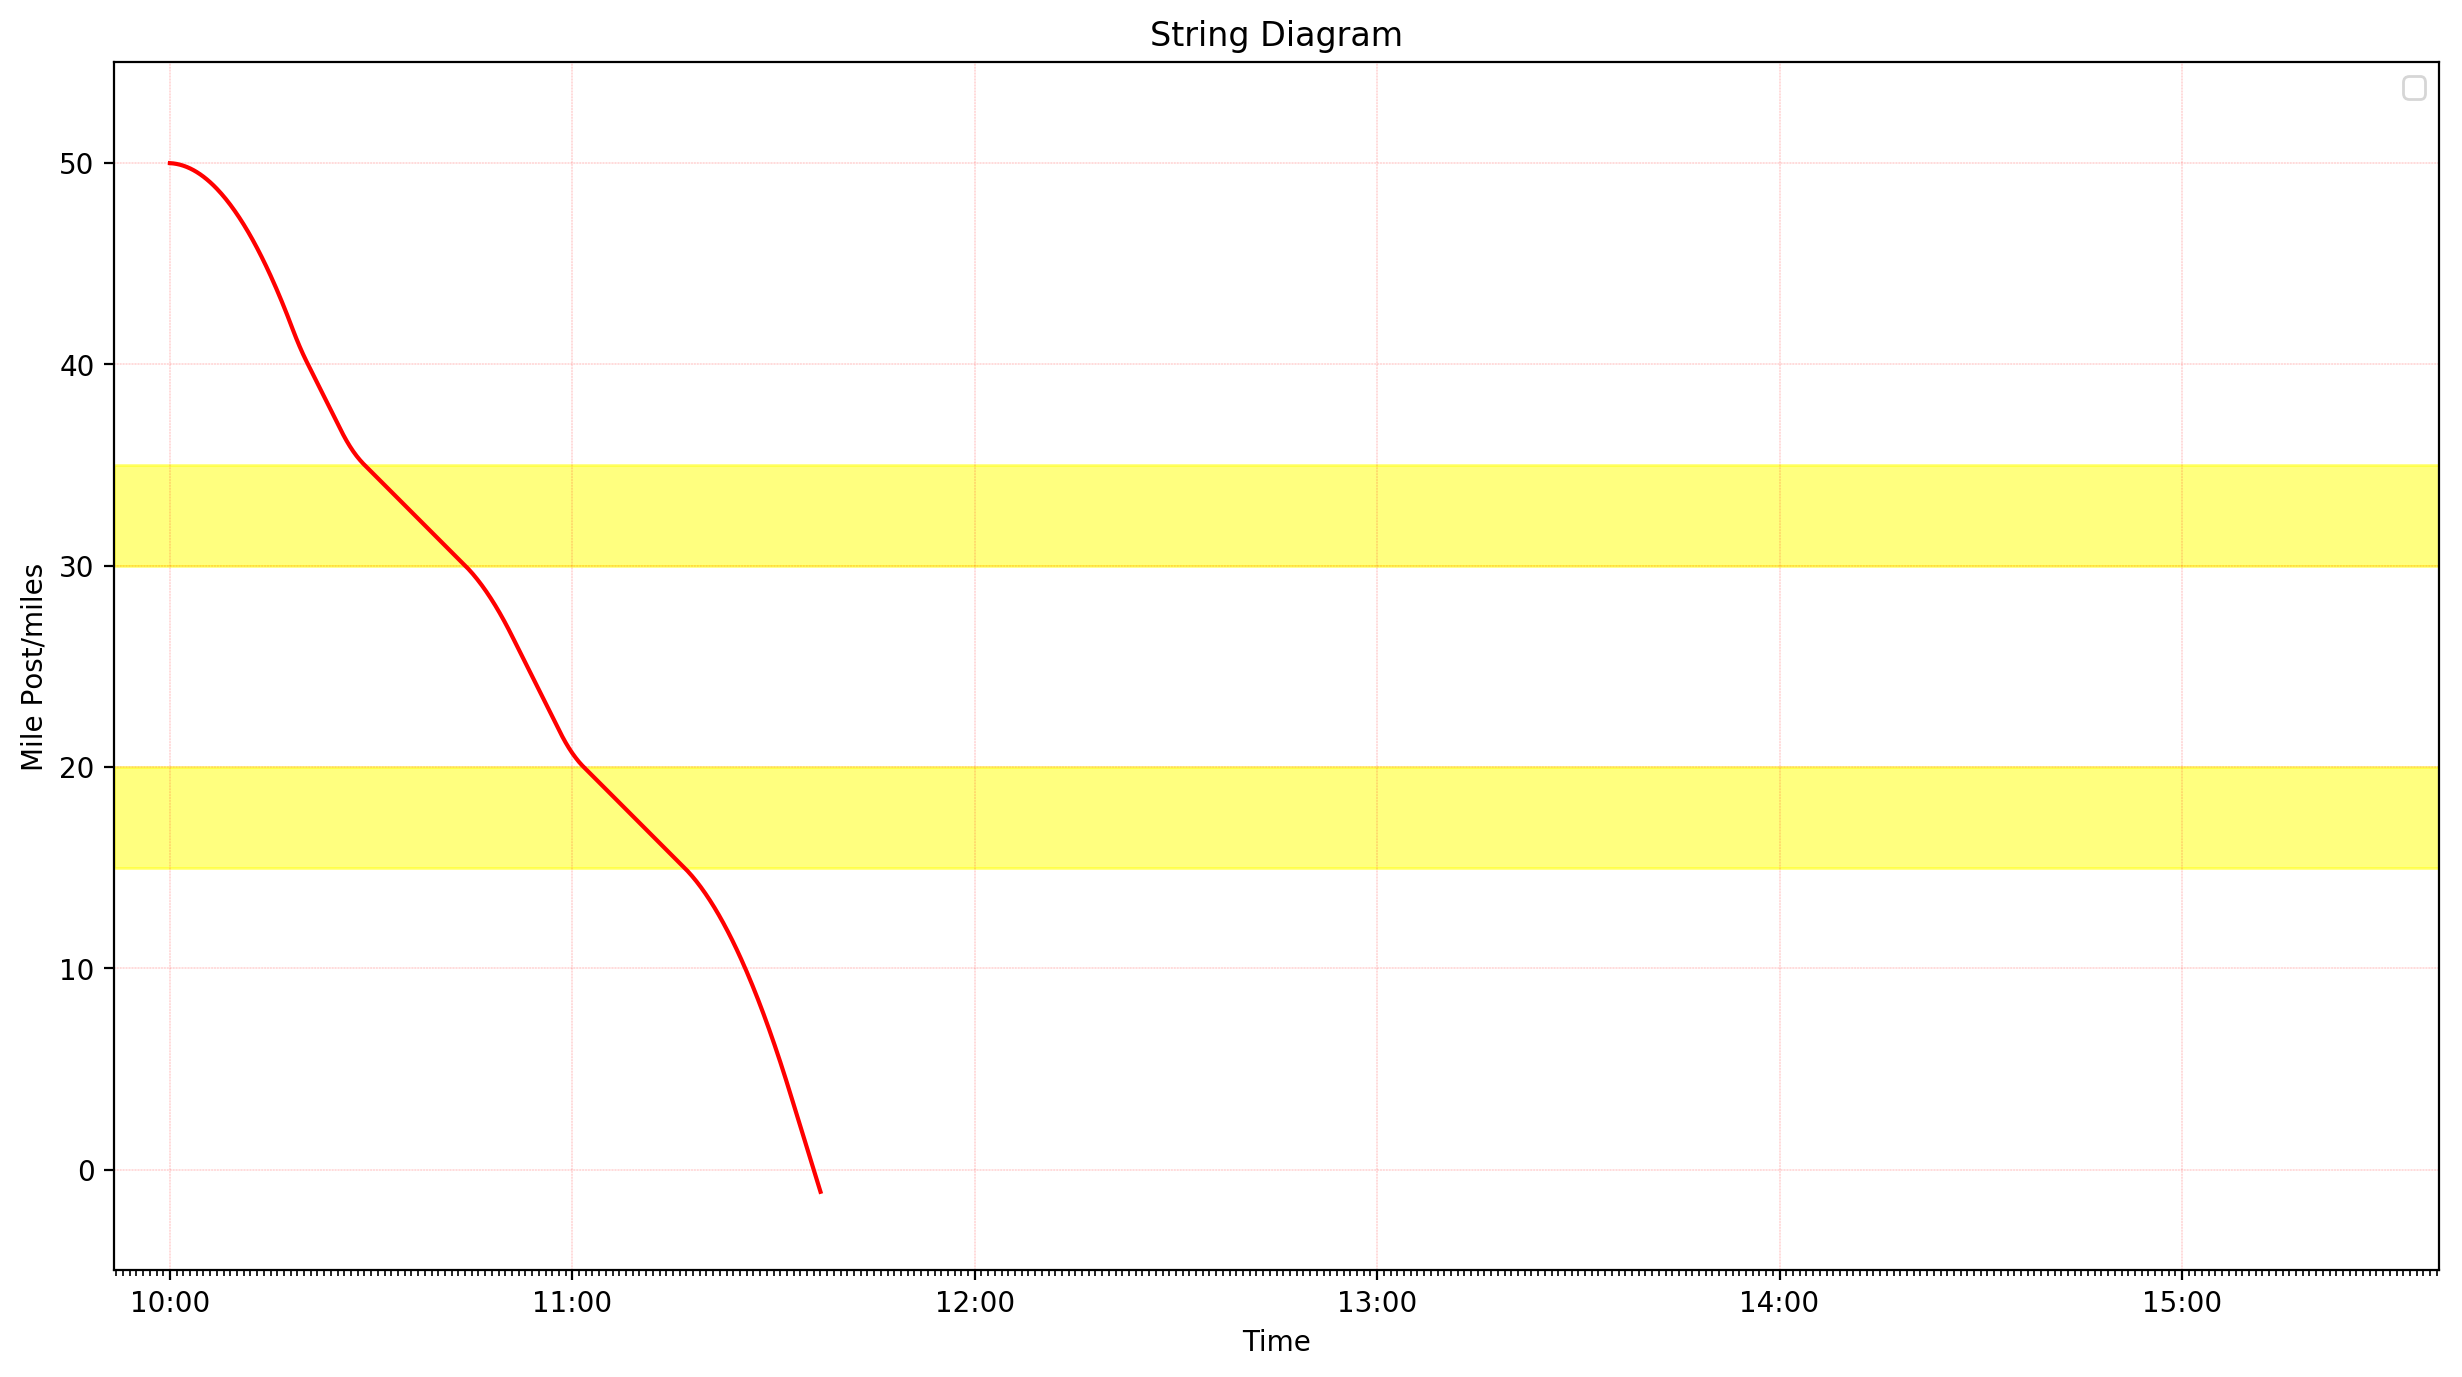

<Figure size 1440x1280 with 0 Axes>

In [6]:
from infrastructure import Track,BigBlock
from system import System
from train import Train
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
def string_diagram(sys, start_time, end_time):
    '''To draw the string diagram based on the schedule dictionary for all the trains. 
    '''
    colors = ['red','green','blue','black','orange','cyan','magenta']
    color_num = len(colors)
    x, y = [], []
    for i in range(len(sys.trains)):
        x.append([])
        y.append([])
        for j in range(len(sys.trains[i].time_pos_list)):
            x[i].append(datetime.fromtimestamp(sys.trains[i].time_pos_list[j][0]))
            y[i].append(sys.trains[i].time_pos_list[j][1])
            # x[i].append(sys.trains[i].time_pos_list[j][0])
            # y[i].append(sys.trains[i].time_pos_list[j][1])

    assert len(x) == len(y)
    for i in range(len(x)):
        assert len(x[i]) == len(y[i])
    train_idx = list(range(len(x)))
    t_color = [colors[i%color_num] for i in range(len(x))]
    min_t, max_t = min([i[0] for i in x if i]), max([i[-1] for i in x if i])
    
    #plt.ion()
    plt.title('String Diagram')
    hours = mdates.HourLocator()
    minutes = mdates.MinuteLocator()
    seconds = mdates.SecondLocator()
    dateFmt = mdates.DateFormatter("%H:%M")
    plt.gca().xaxis.set_major_locator(hours)
    plt.gca().xaxis.set_minor_locator(minutes)
    plt.gca().xaxis.set_major_formatter(dateFmt)
    plt.xticks(rotation=90)
    plt.grid(True, linestyle = "-.", color = "r", linewidth = "0.1")
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Mile Post/miles')
    start_time = int(start_time.timestamp())
    end_time = int(end_time.timestamp())
    plt.axis([(datetime.fromtimestamp(start_time - 500)), \
            (datetime.fromtimestamp(end_time + 500)), -5 , 55])
    #===============================================================================
    # time_length = end_time - start_time
    # step_size = 10
    # for start in range(1,time_length + 1, step_size):
    #     plt.axis([(datetime.fromtimestamp(start_time - 500)), \
    #         (datetime.fromtimestamp(end_time + 500)), -5 , 55])
         
    #     for n in range(len(x)-1):
    #         new_x_y = [[mdates.date2num(datetime.fromtimestamp(i)), j] for i, j in zip(x[n], y[n]) if i < start_time + start and i > start_time + start - 1 - step_size]
    #         new_x = []
    #         new_y = []
    #         for i , j in new_x_y:
    #             new_x.append(i)
    #             new_y.append(j)
    #         if(len(new_x) == 0):
    #             continue
    #         plt.plot(new_x, new_y, color=t_color[n])
    #         # print('==============')
    #         # print('Length of new_x: {}'.format(len(new_x)))
    #         # print('Length of new_y: {}'.format(len(new_y)))
    #     plt.pause(0.00001)
    #===============================================================================
    for n in range(len(x)):
        plt.plot([mdates.date2num(i) for i in x[n]], y[n], color=t_color[n])
    plt.gca().axhspan(15,20,color='yellow',alpha=0.5)
    plt.gca().axhspan(30,35,color='yellow',alpha=0.5)
#     plt.gca().axvspan((datetime.fromtimestamp(start_time + 90 * 60)),(datetime.fromtimestamp(start_time + 150 * 60)),color='black',alpha=0.5)
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.dpi'] = 200
    import pylab; pylab.rcParams['figure.figsize'] = (15.0, 8.0)
    plt.show()
    #plt.ioff()
def speed_curve(sys, train):
    '''To draw the speed curve based on a train's mileposts and speed . 
    '''
    colors = ['red','green','purple']
    mp, spd, spdlmt, tgt_spd = [], [], [], []
    for i in range(len(train.pos_spd_list)):
        mp.append(train.pos_spd_list[i][0])
        spd.append(abs(train.pos_spd_list[i][1]*3600))
        spdlmt.append(train.pos_spd_list[i][2]*3600)
        tgt_spd.append(train.pos_spd_list[i][3]*3600)

    min_mp, max_mp = min(mp), max(mp)
    
    #plt.ion()
    plt.title('Speed Curve')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle = "-.", color = "r", linewidth = "0.1")
    plt.legend()
    plt.xlabel('Mile Post/miles')
    plt.ylabel('MPH')
    plt.plot(mp, spd, color=colors[1])  # train speed
    plt.plot(mp, spdlmt, color=colors[0])  # train speed lmt
    plt.plot(mp, tgt_spd, '--', color=colors[2])  # train tgt speed
    
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.dpi'] = 200
    import pylab; pylab.rcParams['figure.figsize'] = (15.0, 8.0)
    plt.show()
    #plt.ioff()
string_diagram(sys, sim_init_time, sim_term_time)
# speed_curve(sys, K166)

In [18]:
print(K166)
print(T166)
print(K165)
print(T165)

train index 0, current occupation: [((ControlPoint7, 2), (ControlPoint6, 3))], head MP: 30.48, rear MP 31.48
train index 1, current occupation: [((ControlPoint4, 2), (ControlPoint3, 3))], head MP: 18.96, rear MP 19.96
train index 2, current occupation: [((AutoPoint2, 1), (ControlPoint3, 0))], head MP: 15.00, rear MP 14.00
train index 3, current occupation: [((ControlPoint4, 1), (AutoPoint5, 0)), ((ControlPoint3, 1), (ControlPoint4, 0))], head MP: 20.00, rear MP 19.00


In [7]:
K166.rear_curr_MP

-0.10842470864122672

In [20]:
_enterable=True
for n in T165.system.control_points:
    if (n.MP - T165.curr_control_point.MP) * T165.sign_MP(T165.curr_routing_path_segment) > 0:
        if not T165.system.capacity_enterable(T165.curr_control_point, n):
            _enterable=False
print(_enterable)

True


In [27]:
T165.curr_control_point.current_routes

[(1, 0)]

In [14]:
r

((ControlPoint10, 0), (ControlPoint7, None))

In [31]:
delta_s = T166.curr_speed * T166.system.refresh_time + 0.5 * (-T166.max_acc) * T166.system.refresh_time**2

In [32]:
(T166.curr_sig.MP-T166.curr_MP)*(T166.curr_sig.MP-(T166.curr_MP+delta_s))

-0.06333881577705458

In [ ]:
print(sys.trains)
sys.signal_points[0].open_route((0,1))
sys.signal_points[10].open_route((1,0))
while T165.rear_curr_MP<=0 and T166.rear_curr_MP>=50:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time
sys.signal_points[0].open_route((0,1))
sys.signal_points[10].open_route((1,0))
# both all the trains to enter the system
sys.signal_points[7].open_route((1,2))
sys.signal_points[6].open_route((0,1))
sys.signal_points[3].open_route((0,1))
sys.signal_points[4].open_route((0,1))
# T166 to meet T165 at siding 2
while T165.rear_curr_MP<=15:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time
sys.signal_points[3].open_route((0,3))
while T165.rear_curr_MP<=30:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time  
sys.signal_points[6].open_route((3,0))
sys.signal_points[4].open_route((1,0))
while T166.rear_curr_MP>=30:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time  
sys.signal_points[7].open_route((1,2))
while K166.rear_curr_MP>=35:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time
sys.signal_points[6].open_route((3,0))   
sys.signal_points[7].open_route((0,1))   
sys.signal_points[10].open_route((0,1))
while T166.rear_curr_MP>=20:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time
sys.signal_points[4].open_route((2,1))
sys.signal_points[6].open_route((3,0))
sys.signal_points[3].open_route((1,0))
sys.signal_points[0].open_route((1,0))
while T165.rear_curr_MP<=50:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time
sys.signal_points[10].open_route((0,1))
while K165.rear_curr_MP<=50:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time

# while T166.rear_curr_MP>=30:
#     T166.update_acc()
#     T165.update_acc()
#     K166.update_acc()
#     K165.update_acc()
#     sys.sys_time+=sys.refresh_time
# sys.signal_points[7].open_route((1,2))
# while K166.rear_curr_MP>=35:
#     T166.update_acc()
#     T165.update_acc()
#     K166.update_acc()
#     K165.update_acc()
#     sys.sys_time+=sys.refresh_time
# sys.signal_points[6].open_route((3,0))
# sys.signal_points[4].open_route((3,0))    
# sys.signal_points[7].open_route((0,1))
# sys.signal_points[10].open_route((0,1))


# sys.signal_points[10].open_route((1,0))
# sys.signal_points[7].open_route((1,0))
# sys.signal_points[6].open_route((1,0))
# sys.signal_points[4].open_route((1,0))
# count=0
# while T166.rear_curr_MP>20:
#     count+=1
#     T166.update_acc()
#     T165.update_acc()
#     sys.sys_time+=sys.refresh_time
# print(count)
# sys.signal_points[0].open_route((1,0))
# sys.signal_points[3].open_route((1,0))
# sys.signal_points[10].open_route((0,1))
# sys.signal_points[7].open_route((0,1))
# sys.signal_points[6].open_route((0,1))
# sys.signal_points[4].open_route((2,1))
# count=0
# while not T165.stopped:
#     count+=1
#     T166.update_acc()
#     T165.update_acc()
#     sys.sys_time+=sys.refresh_time
# print(count)